# Iowa Liquor Sales Analysis
Prepared by Steve Pisani

Below is the analysis on the provided case study data. In addition to this notebook, this repo showcases a data ingestion script (_found in `./1_data_ingestion`_) and a dbt project for data cleanup and prep (_found in `./2_data_transformation`_). 


## Set Vars
In a production, environment this is a big no no.

In [1]:
SNOWFLAKE_ACCOUNT = 'ACCOUNT'
SNOWFLAKE_USER = 'USER'
SNOWFLAKE_PASSWORD = 'PASSWORD'
SNOWFLAKE_WAREHOUSE = 'compute_wh'
SNOWFLAKE_DATABASE = 'analytics'
SNOWFLAKE_SCHEMA = 'IOWA_LIQUOR_SALES'

## Load data

In [9]:
import snowflake.connector
import pandas as pd

conn = snowflake.connector.connect(
            user=SNOWFLAKE_USER,
            password=SNOWFLAKE_PASSWORD,
            account=SNOWFLAKE_ACCOUNT,
            warehouse=SNOWFLAKE_WAREHOUSE,
            database=SNOWFLAKE_DATABASE,
            schema=SNOWFLAKE_SCHEMA
        )

# Load the cleaned data into a Pandas DataFrame
invoices_df = pd.read_sql(
  sql='SELECT * FROM analytics.marts.invoices',
  con=conn,
)
conn.close()

# Print the DataFrame
invoices_df.head()


,INVOICE_ID,INVOICE_DATE,STATE_BOTTLE_COST,STATE_BOTTLE_RETAIL,NUMBER_OF_BOTTLES_SOLD,SALE_IN_DOLLARS,COST_IN_DOLLARS,PROFIT_IN_DOLLARS,VOLUME_SOLD_LITERS,VOLUME_SOLD_GALLONS,...,STORE_BRAND_NAME,CATEGORY_ID,CATEGORY_NAME,LIQUOR_TYPE_NAME,VENDOR_ID,VENDOR_NAME,ITEM_ID,ITEM_DESCRIPTION,NUMBER_OF_BOTTLES_IN_PACK,BOTTLE_VOLUME_ML
0,31873800014,2020-11-12,7.47,11.21,1,11.21,7.47,3.74,0.05,0.01,...,quik trip,1031100.0,american vodkas,vodkas,260.0,diageo americas,37991,smirnoff 80prf mini,12,50
1,31873800015,2020-11-12,4.75,7.13,5,35.65,23.75,11.90,1.87,0.49,...,quik trip,1031100.0,american vodkas,vodkas,260.0,diageo americas,37994,smirnoff 80prf,24,375
2,31873800016,2020-11-12,11.50,17.25,1,17.25,11.50,5.75,0.05,0.01,...,quik trip,1022100.0,mixto tequila,tequilas & mezcal,395.0,proximo,89191,jose cuervo especial reposado mini,12,50
3,31873800017,2020-11-12,3.00,4.50,2,9.00,6.00,3.00,0.40,0.10,...,quik trip,1022100.0,mixto tequila,tequilas & mezcal,395.0,proximo,89193,jose cuervo especial reposado,48,200
4,31873800018,2020-11-12,5.50,8.25,6,49.50,33.00,16.50,2.25,0.59,...,quik trip,1022100.0,mixto tequila,tequilas & mezcal,395.0,proximo,89194,jose cuervo especial reposado flask,24,375


## 1. What impact did Covid have on the overall liquor market in Iowa?

In [10]:
# Convert the 'INVOICE_DATE' column to datetime format
invoices_df['INVOICE_DATE'] = pd.to_datetime(invoices_df['INVOICE_DATE'])

# Extract year from 'INVOICE_DATE'
invoices_df['YEAR'] = invoices_df['INVOICE_DATE'].dt.year

# Group data by year and sum up the sales and volume
annual_sales_volume = invoices_df.groupby('YEAR')[['SALE_IN_DOLLARS', 'VOLUME_SOLD_LITERS']].sum()

# Filter out data only for 2019, 2020, and 2021
annual_sales_volume = annual_sales_volume.loc[[2019, 2020, 2021]]

annual_sales_volume


,SALE_IN_DOLLARS,VOLUME_SOLD_LITERS
YEAR,,
2019,3.492193e+08,22301328.92
2020,3.966620e+08,24211592.80
2021,4.281216e+08,24755258.31


The overall liquor market in Iowa saw the following changes during the COVID-19 period:

1. 2019 (Pre-COVID):

  Sales: $349,219,300
  Volume Sold: 22,301,328 liters
  
2. 2020 (COVID onset):

  Sales: $396,662,000 (an increase of about 12.7% from 2019)
  Volume Sold: 24,211,592 liters (an increase of about 8.2% from 2019)
  
3. 2021 (Post-COVID)

  Sales: $428,121,600 (an increase of about 7.6% from 2020)
  Volume Sold: 24,755,258 liters (an increase of about 2.2% from 2020)
  

From these numbers, we can infer:

The liquor market in Iowa saw growth both in terms of sales and volume during the COVID-19 period.
The year 2020, which marks the onset of COVID, saw an increase in sales and volume compared to 2019.
This growth trend continued into 2021, with even higher sales and volume compared to 2020.


### 1a. What trends evolved over the next 3-18 months?

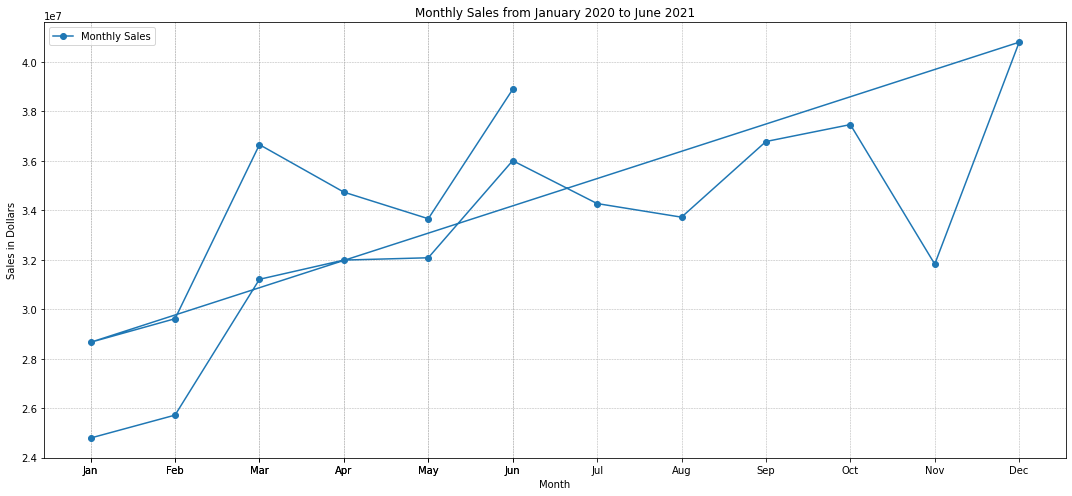

In [11]:
# Extract month and year from 'INVOICE_DATE'
invoices_df['MONTH'] = invoices_df['INVOICE_DATE'].dt.month

# Group data by year and month, then sum up the sales
monthly_sales = invoices_df.groupby(['YEAR', 'MONTH'])['SALE_IN_DOLLARS'].sum().reset_index()

# Filter out data for January 2020 to June 2021
monthly_sales = monthly_sales[(monthly_sales['YEAR'] == 2020) | 
                              ((monthly_sales['YEAR'] == 2021) & (monthly_sales['MONTH'] <= 6))]

# Plotting the monthly sales for the period
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(monthly_sales['MONTH'], monthly_sales['SALE_IN_DOLLARS'], marker='o', label='Monthly Sales')
plt.title('Monthly Sales from January 2020 to June 2021')
plt.xlabel('Month')
plt.ylabel('Sales in Dollars')
plt.xticks(monthly_sales['MONTH'], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The monthly sales trend from January 2020 to June 2021 indicates:

Sales began to rise starting in January 2020 and peaked around March.
There was a noticeable dip in April, likely reflecting the immediate impacts of COVID-19 lockdowns and restrictions.
Post-April, sales began to recover steadily and maintained an upward trajectory throughout the year.
By January 2021, sales had surged again and remained relatively high for the first half of the year, with a few fluctuations.


### 1b. Was there a notable shift in the types of products purchased in terms of pack size

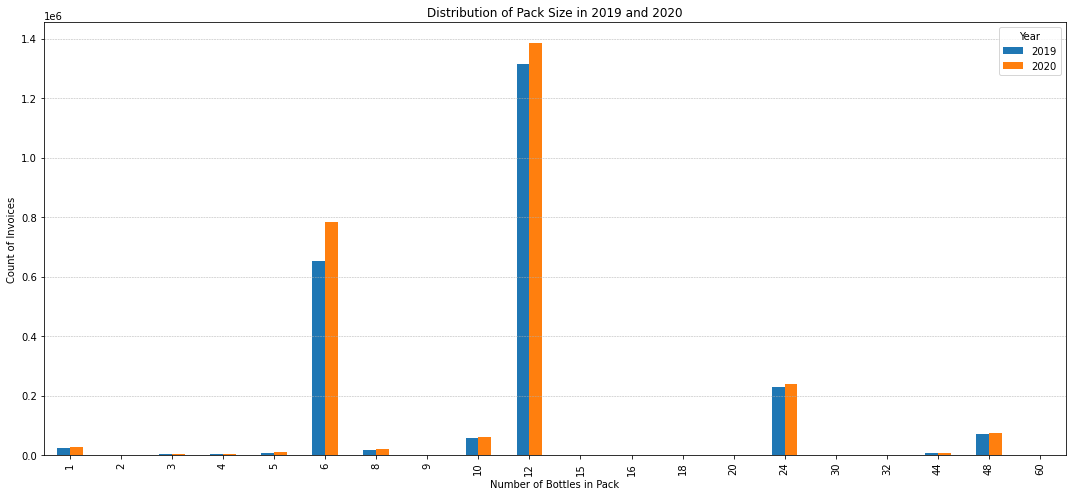

In [12]:
# Group by year and 'NUMBER_OF_BOTTLES_IN_PACK' and count the number of invoices for each pack size
pack_size_distribution = invoices_df.groupby(['YEAR', 'NUMBER_OF_BOTTLES_IN_PACK']).size().reset_index(name='COUNT')

# Filter for years 2019 and 2020
pack_size_distribution = pack_size_distribution[pack_size_distribution['YEAR'].isin([2019, 2020])]

# Pivot the data for better visualization
pack_size_pivot = pack_size_distribution.pivot(index='NUMBER_OF_BOTTLES_IN_PACK', columns='YEAR', values='COUNT').fillna(0)

# Plotting the distribution
pack_size_pivot.plot(kind='bar', figsize=(15, 7))
plt.title('Distribution of Pack Size in 2019 and 2020')
plt.xlabel('Number of Bottles in Pack')
plt.ylabel('Count of Invoices')
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The distribution of pack sizes in 2019 (pre-COVID) and 2020 (COVID onset) reveals the following:

The most popular pack sizes in both years were 6, 12, and 24 bottles per pack.
In 2020, there was a noticeable increase in purchases of packs containing 6 and 12 bottles compared to 2019.
On the contrary, packs with 24 bottles saw a slight decrease in 2020 compared to 2019.
Other pack sizes also experienced changes, but the most significant shifts were observed in the 6, 12, and 24 bottle packs.


## 2. Which are the fastest growing types of liquor (e.g., vodka, tequila, rum, etc.)? How has market share changed over time?

In [13]:
# Group by year and 'LIQUOR_TYPE_NAME' and sum the sales for each type of liquor
liquor_sales_by_type = invoices_df.groupby(['YEAR', 'LIQUOR_TYPE_NAME'])['SALE_IN_DOLLARS'].sum().reset_index()

# Pivot the data to get sales for each year as separate columns
liquor_sales_pivot = liquor_sales_by_type.pivot(index='LIQUOR_TYPE_NAME', columns='YEAR', values='SALE_IN_DOLLARS').fillna(0)

# Calculate the growth rate from 2019 to 2021
liquor_sales_pivot['GROWTH_RATE'] = ((liquor_sales_pivot[2021] - liquor_sales_pivot[2019]) / liquor_sales_pivot[2019]) * 100

# Sort by growth rate in descending order to identify the fastest growing types
fastest_growing_liquors = liquor_sales_pivot[['GROWTH_RATE']].sort_values(by='GROWTH_RATE', ascending=False)

fastest_growing_liquors


YEAR,GROWTH_RATE
LIQUOR_TYPE_NAME,
tequilas & mezcal,59.506890
liqueurs & cordials,31.173845
specialty & miscellaneous,26.378939
whiskies,22.636508
gins,17.250531
vodkas,11.327505
rums,11.137665


It's evident that **Tequilas & Mezcal** experienced the highest growth, followed by Vodkas.

### a. Function to Visualize Market Share Over Time

In [14]:
def visualize_market_share(liquor_types):
    """
    Function to visualize market share over time for the provided list of liquor types.
    
    Parameters:
    - liquor_types (list): List of liquor types to visualize.
    
    Returns:
    - A plot showing market share over time for the specified liquor types.
    """
    
    # Filter data for the specified liquor types
    filtered_data = liquor_sales_by_type[liquor_sales_by_type['LIQUOR_TYPE_NAME'].isin(liquor_types)]
    
    # Calculate total sales for each year
    total_sales_per_year = liquor_sales_by_type.groupby('YEAR')['SALE_IN_DOLLARS'].sum()
    
    # Calculate market share
    filtered_data['MARKET_SHARE'] = filtered_data.apply(lambda row: (row['SALE_IN_DOLLARS'] / total_sales_per_year[row['YEAR']]) * 100, axis=1)
    
    # Pivot data for plotting
    market_share_pivot = filtered_data.pivot(index='YEAR', columns='LIQUOR_TYPE_NAME', values='MARKET_SHARE')
    
    # Plot
    plt.figure(figsize=(15, 7))
    market_share_pivot.plot(ax=plt.gca())
    plt.title('Market Share Over Time for Selected Liquor Types')
    plt.xlabel('Year')
    plt.ylabel('Market Share (%)')
    plt.legend(title='Liquor Type')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


/opt/anaconda3/envs/notebooks/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


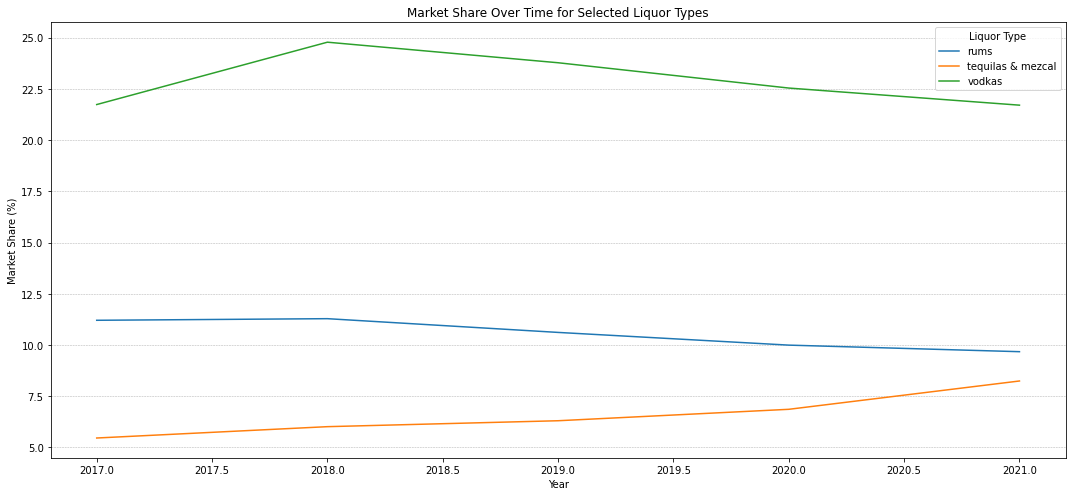

In [15]:
# Test the function with a few liquor types
visualize_market_share(['tequilas & mezcal', 'vodkas', 'rums'])


This visual reveals:
- **Tequilas & Mezcal**: A clear upward trend in market share, indicating its increasing popularity.
- **Vodkas**: A downward trend, suggesting customers are choosing other options.
- **Rums**: A relatively stable market share over the three years.


### b. What is driving the growth in tequila sales? Increases in average price or increases in volume sold?


In [16]:
# Filter data for 'tequilas & mezcal'
tequila_data = invoices_df[invoices_df['LIQUOR_TYPE_NAME'] == 'tequilas & mezcal']

# Group by year and calculate total volume sold and total sales
tequila_metrics = tequila_data.groupby('YEAR').agg({
    'VOLUME_SOLD_LITERS': 'sum',
    'SALE_IN_DOLLARS': 'sum'
}).reset_index()

# Calculate average price per liter for each year
tequila_metrics['AVERAGE_PRICE_PER_LITER'] = tequila_metrics['SALE_IN_DOLLARS'] / tequila_metrics['VOLUME_SOLD_LITERS']

tequila_metrics[['YEAR', 'VOLUME_SOLD_LITERS', 'AVERAGE_PRICE_PER_LITER']]


,YEAR,VOLUME_SOLD_LITERS,AVERAGE_PRICE_PER_LITER
0,2017,33488.53,24.944636
1,2018,869827.26,23.050524
2,2019,932718.25,23.535318
3,2020,1066478.85,25.325843
4,2021,1267139.36,27.632846


1. **Volume Sold**:
There has been a consistent increase in the volume of Tequilas & Mezcal sold each year.

2. **Average Price per Liter**:
The average price per liter has also been increasing.
From 2019 to 2021, the average price per liter increased from approximately $24.94 to $27.63.


From this analysis, it's evident that the growth in Tequila sales is driven by both an increase in volume sold and an increase in the average price. Both factors have contributed to the overall growth in Tequila sales during this period.



In [18]:
# Group by year and 'STORE_BRAND_NAME' and sum the sales for each retailer
retailer_sales = invoices_df.groupby(['YEAR', 'STORE_BRAND_NAME'])['SALE_IN_DOLLARS'].sum().reset_index()

In [28]:
# Rank the retailers based on sales for each year
retailer_sales['RANK'] = retailer_sales.groupby('YEAR')['SALE_IN_DOLLARS'].rank(method='first', ascending=False)
# Clean up the brand names
retailer_sales['STORE_BRAND_NAME'] = retailer_sales['STORE_BRAND_NAME'].map({
    'hy':'Hy-Vee',
    'fareway stores':'Fareway Stores',
    'wal':'Wal-Mart',
    'sam\'s club':'Sam\'s Club',
    'central city':'Central City',
    'casey\'s general store':'Casey\'s General Store',
    'target':'Target',
    'walgreens':'Walgreens',
    'kum & go':'Kum & Go',
    'wilkie liquors':'Wilkie Liquors',
    'lot':'Lot-A-Spirits',
    'costco wholesale':'Costco Wholesale',
    'benz distributing':'Benz Distributing'
})

# Filter for top 10 retailers for each year
top_10_retailers = retailer_sales[retailer_sales['RANK'] <= 10].pivot(index='RANK', columns='YEAR', values='STORE_BRAND_NAME')

# top_10_retailers[['YEAR','STORE_BRAND_NAME','RANK']].sort_values(['YEAR','RANK'])
top_10_retailers

YEAR,2017,2018,2019,2020,2021
RANK,,,,,
1.0,Hy-Vee,Hy-Vee,Hy-Vee,Hy-Vee,Hy-Vee
2.0,Fareway Stores,Fareway Stores,Fareway Stores,Fareway Stores,Fareway Stores
3.0,Wal-Mart,Wal-Mart,Wal-Mart,Wal-Mart,Sam's Club
4.0,Sam's Club,Sam's Club,Sam's Club,Sam's Club,Casey's General Store
5.0,Central City,Central City,Central City,Casey's General Store,Wal-Mart
6.0,Casey's General Store,Casey's General Store,Casey's General Store,Costco Wholesale,Central City
7.0,Kum & Go,Kum & Go,Kum & Go,Central City,Costco Wholesale
8.0,Costco Wholesale,Costco Wholesale,Costco Wholesale,Kum & Go,Kum & Go
9.0,NaN,Wilkie Liquors,Wilkie Liquors,NaN,Benz Distributing


It's evident that some brands like Hy-VEE, Fareway Stores, and Sam's Club have consistently been among the top retailers across the years. That said, there has movement across the rankings.

It is also evident that my store brand code has some room for improvement

4. In late 2019 Heaven Hill Brands bought a portfolio of liquor brands from Constellation Brands. What percentage of Heaven Hill’s growth in 2020 can be attributed to the acquisition?

In [30]:
# List of acquired item_ids
## Retrived from Snowflake
acquired_items = [
    10548, 11588, 13928, 11771, 10550, 11776, 11786, 903141, 911056, 
    11788, 11777, 11371, 11586, 11774, 11773
]

# Filter data for Heaven Hill Brands in 2020 for the acquired items
heaven_hill_sales_2020_acquired = invoices_df[
    (invoices_df['VENDOR_NAME'] == 'heaven hill brands') & 
    (invoices_df['YEAR'] == 2020) & 
    (invoices_df['ITEM_ID'].isin(acquired_items))
]['SALE_IN_DOLLARS'].sum()

# Calculate total sales for Heaven Hill Brands in 2019 and 2020
heaven_hill_sales_2019 = invoices_df[(invoices_df['VENDOR_NAME'] == 'heaven hill brands') & (invoices_df['YEAR'] == 2019)]['SALE_IN_DOLLARS'].sum()
heaven_hill_sales_2020 = invoices_df[(invoices_df['VENDOR_NAME'] == 'heaven hill brands') & (invoices_df['YEAR'] == 2020)]['SALE_IN_DOLLARS'].sum()

# Calculate growth of Heaven Hill Brands from 2019 to 2020
heaven_hill_growth = heaven_hill_sales_2020 - heaven_hill_sales_2019

# Calculate the growth attributed to the acquired portfolio
acquisition_growth = heaven_hill_sales_2020_acquired

# Calculate the percentage of Heaven Hill's growth attributed to the acquisition
percentage_growth_attributed = (acquisition_growth / heaven_hill_growth) * 100

heaven_hill_sales_2020_acquired, percentage_growth_attributed


(17291774.49, 106.98385641120585)

Sales of the acquired portfolio under Heaven Hill Brands in 2020: $17,291,774.49
Percentage of Heaven Hill Brands' growth in 2020 attributed to the acquisition: Approximately 106.98%

It's interesting to note that the growth attributed to the acquired portfolio is greater than 100%. This suggests that while Heaven Hill Brands experienced overall growth due to the acquired items, other parts of their portfolio might have seen a decline in sales.



## 5. What data integrity issues did you discover? How could you (or how did you) solve/account for these?


In its raw form, the dataset is a denormalized fact table with information on all entities involved in a transaction such as item, store, and vendor. Each of these entities also has a set of dimensions that would slowly change over time which would make analyses over long periods of time challenging. Additionally, some useful dimensions were not present in the raw dataset such as Store Brand.

To solve this, I first ingest the data into Snowflake and used dbt to normalize and clean the data before rejoining for analysis in this notebook.

### a. Comment on any data issues you discovered and what assumptions you used to deal with them.

As mentioned above, some dimensions in the entities such as which names, ids and associations changed over time in the raw dataset. To deal with these issues, I used a window function to take the latest values for a particular primary key.

In a production setting, I would suggest creating an effective from / to field on each primary key to value in each entity and joining to a date spine for quick analysis when needed.

### b. What’s a simple solution to solving data quality issues?

A simple solution may have been to load the data into a dataframe in the notebook directly and clean each column separately.

For some missing fields and hotfixes (_such as the brand name mappings_), I did so in this notebook.

### c. What would be a more scalable solution to deal with quality issues?

I would expand upon the framework I have created, adding more tests on the modeled data and the raw data as it is ingested. I would also suggest looking for better endpoints to ingest the raw data from to avoid having to do the heavy normalization work.